# 🧠 AI Second Brain for PDFs

An intelligent study assistant that transforms any PDF into an interactive learning experience using **RAG + LLMs**.

---

## 🚀 Features
- Explain any topic from the PDF
- Smart summaries
- Quiz generation
- Flashcards
- Study plans
- Mind maps
- Weakness analysis
- Exam-style questions
- API deployment via FastAPI + Ngrok

---

## 🏗️ System Architecture

PDF → Text → Chunking → Embeddings → FAISS  
→ Retriever → LLM → Study Modes

---

## 🎯 Goal
Turn static PDFs into a **personal AI tutor**.


In [ ]:
!pip -q install -U \
  python-dotenv pypdf \
  langchain langchain-community langchain-text-splitters \
  langchain-groq \
  faiss-cpu sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.6/330.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.5/500.5 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires re

## 1. Imports & Setup

Loading all required libraries for:
- RAG pipeline
- Embeddings
- LLM
- Vector database
- API deployment


In [ ]:
import os
import re
import json
import uuid
import time
import socket
import uvicorn
import requests
import threading

import networkx as nx
import matplotlib.pyplot as plt

from dotenv import dotenv_values

from pypdf import PdfReader
from typing import Optional, Literal, Dict, Any
from fastapi import FastAPI, Request, HTTPException, UploadFile, File

from pydantic import BaseModel
from pyngrok import ngrok, conf

from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
env_values = dotenv_values("./key.env")
openai_api_key = env_values['key']

### Get the `Groq` LLM

In [ ]:
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key=openai_api_key,
    temperature=0.7,
    max_tokens=512
)

## 2. Student Profile

Personalized learning system based on:

- Level
- Goal
- Exam date
- Study hours
- Weak topics


### Build Profile before Uploading PDF


In [ ]:
profile = {
    "domain": "Any (User enters)",
    "goal": "Exam",
    "level": "Intermediate",
    "daily_time": 90,
    "exam_date": "",
    "style": "Step-by-step"
    }


In [ ]:
def format_profile(p: dict) -> str:
    return (
        f"Field/Domain: {p.get('domain')}\n"
        f"Goal: {p.get('goal')}\n"
        f"Level: {p.get('level')}\n"
        f"Daily time: {p.get('daily_time')} minutes\n"
        f"Exam date: {p.get('exam_date')}\n"
        f"Preferred style: {p.get('style')}\n"
    )


In [ ]:
print(format_profile(profile))

Field/Domain: Any (User enters)
Goal: Exam
Level: Intermediate
Daily time: 90 minutes
Exam date: 
Preferred style: Step-by-step



## 3. Load & Process PDF

Steps:
1. Read PDF
2. Extract text
3. Create documents
4. Prepare for chunking


### Make a function that read `PDF paths`

In [ ]:
def read_pdf_text(pdf_path: str) -> str:
    reader = PdfReader(pdf_path)
    parts = []
    for page in reader.pages:
        parts.append(page.extract_text() or "")
    return "\n".join(parts).strip()

In [ ]:
pdf_paths = [
    "/content/Alzheimer_Disease_Report .pdf"

]

In [ ]:
docs = []
for path in pdf_paths:
    text = read_pdf_text(path)
    if not text:
        continue
    docs.append(Document(page_content=text, metadata={"source": os.path.basename(path)}))

In [ ]:
print(docs)

[Document(metadata={'source': 'Alzheimer_Disease_Report .pdf'}, page_content='Name; Yasmin Mamdouh Moghazy A4 \nID; 392300036  \n                                                   Alzheimer’s Disease \nIntroduction \nAlzheimer’s disease (AD) is a progressive neurodegenerative disorder and the most \ncommon cause of dementia worldwide. It primarily affects memory, thinking abilities, \nbehavior, and the capacity to perform daily activities. As the disease advances, neuronal \ndeath and brain tissue loss lead to significant cognitive decline and functional impairment. \nAlzheimer’s disease is most commonly associated with aging, though it is not considered a \nnormal part of the aging process. \nDefinition and Overview \nAlzheimer’s disease is characterized by the abnormal buildup of proteins in the brain, \nespecially beta-amyloid plaques and tau neurofibrillary tangles. These pathological changes \ndisrupt communication between neurons and eventually cause neuronal death. The disease \

## 4. Text Chunking

Splitting the document into smaller chunks for better retrieval.

Why?
- Improves semantic search
- Better LLM context
- Faster retrieval


### Make `Chunks` then make `Embeddings` for each chunk then store these embeddings in Vectore database `FAISS`

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=20
)

chunks = splitter.split_documents(docs)

In [ ]:
len(chunks)

6

## 5. Embeddings & Vector Store

Transform text chunks into vectors using:
- Sentence Transformers
- FAISS vector database

This allows semantic search over the PDF.


In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/tmp/ipython-input-3409896792.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.war

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
vs = FAISS.from_documents(chunks, embeddings)
retriever = vs.as_retriever(search_kwargs={"k": 5})

## 6. Retriever System

Retrieve the most relevant chunks from the PDF  
based on the user's question or topic.


### Make a Retrieval Context Helper function

In [ ]:
def retrieve_context(query: str, k: int = 5) -> str:
    hits = vs.similarity_search(query, k=k)
    ctx = []
    for i, d in enumerate(hits, 1):
        src = d.metadata.get("source", "unknown")
        ctx.append(f"[Source {i}: {src}]\n{d.page_content}")
    return "\n\n".join(ctx)

In [ ]:
BASE_SYSTEM = """
You are Study Brain, a domain-agnostic tutoring assistant.

Core rules (must follow):
1) Use ONLY the provided CONTEXT to answer. Do not use outside knowledge.
2) If the answer is not fully supported by CONTEXT, say: "I don't know from the provided documents."
   Then ask for what to upload (e.g., chapter/notes/topic).
3) Be faithful: no hallucinations, no invented facts, no fake citations.
4) Adapt to the student's PROFILE: level, goal, style, and time.
5) Prefer clarity and learning: explain concepts, give examples when appropriate, and check understanding.
6) When you reference information, mention the source label (e.g., Source 1 / filename) if present in CONTEXT.

Output quality rules:
- Use structured sections with headings.
- Keep the language consistent with the student's preferred style.
- If the user request is ambiguous, ask 1-2 clarifying questions.
"""


In [ ]:
PROFILE_BLOCK = "STUDENT PROFILE:\n{profile}\n"
CONTEXT_BLOCK = "DOCUMENT CONTEXT (ONLY SOURCE OF TRUTH):\n{context}\n"

def make_prompt(task_instructions: str):
    return ChatPromptTemplate.from_messages([
        ("system", BASE_SYSTEM),
        ("human", PROFILE_BLOCK + "\n" + CONTEXT_BLOCK + "\n" + task_instructions)
    ])

## 7. Study Modes

Available modes:

- Explain
- Summarize
- Quiz
- Flashcards
- Study Plan
- Topic Index
- Exam Style
- Weakness Analyzer


In [ ]:
PROMPT_EXPLAIN = make_prompt("""
TASK: Explain the topic below strictly from the CONTEXT.

TOPIC/QUESTION:
{topic}

REQUIREMENTS:
- Match the student's level and preferred style.
- If the topic is not covered in CONTEXT, say you don't know from the documents.
- Use simple, correct analogies ONLY if supported by context or explicitly labeled as analogy.
- Include 1-2 examples if possible from the context.

OUTPUT FORMAT:
1) Title
2) Key Ideas (5-8 bullets)
3) Explanation (step-by-step, level-appropriate)
4) Example(s) (if available)
5) Common Confusions (2-3)
6) Quick Check (3 questions + short expected answers)
""")

PROMPT_SUMMARIZE = make_prompt("""
TASK: Create a structured summary strictly from the CONTEXT for the topic below.

TOPIC:
{topic}

OUTPUT FORMAT:
1) One-paragraph overview (3-5 lines)
2) Key Points (7 bullets)
3) Important Terms (5 items: term - definition)
4) Common Mistakes / Misconceptions (3 bullets)
5) If I only remember 3 things (3 bullets)
""")

PROMPT_QUIZ = make_prompt("""
TASK: Generate an assessment quiz strictly from the CONTEXT about:

TOPIC:
{topic}

REQUIREMENTS:
- Difficulty matches student's level.
- Questions must be answerable ONLY from the context.
- Provide answers and brief rationale referencing Source labels when possible.

OUTPUT FORMAT:
A) MCQ (5 questions)
- Q1 ...?
  A) ...
  B) ...
  C) ...
  D) ...
  Correct: X
  Why: 1-2 lines (cite Source if possible)

B) Short Answer (3 questions)
- Q1 ...
  Model Answer: ...
  Key Points: ...

C) Scoring Rubric
- What makes an answer "excellent" vs "okay" vs "weak" (3 bullets)
""")


PROMPT_FLASHCARDS = make_prompt("""
TASK: Create flashcards strictly from the CONTEXT for:

TOPIC:
{topic}

REQUIREMENTS:
- Make them spaced-repetition friendly.
- Each card should test ONE idea.
- Use simple language for Beginner; more technical for Advanced.

OUTPUT FORMAT (repeat 12 times):
Card 1:
Q: ...
A: ...
Source: (Source # / filename if possible)
""")


PROMPT_STUDY_PLAN = make_prompt("""
TASK: Build a practical 7-day study plan based ONLY on the topics found in CONTEXT.

CONSTRAINTS:
- Use student's daily_time (minutes/day).
- If exam_date exists, prioritize the most important/high-yield topics first.
- Mix learning + practice + revision.

OUTPUT FORMAT:
Day 1:
- Focus Topics: ...
- Activities:
  - Read/Explain: X min
  - Quiz: X min
  - Flashcards: X min
- Outcome: what should the student be able to do?

Repeat Day 2 ... Day 7

END WITH:
- "High-yield topics" list (5 items)
- "Revision strategy" (3 bullets)
""")


PROMPT_TOPIC_INDEX = make_prompt("""
TASK: Extract a clean "Topic Index" from the CONTEXT.

REQUIREMENTS:
- 12 to 20 topics.
- Each topic includes:
  - Short description (1 line)
  - Where it appears (Source labels / filenames if possible)

OUTPUT FORMAT:
1) Topic Index:
- Topic 1: description ... (Sources: ...)
- Topic 2: ...
...
2) Suggested learning order (beginner-friendly) (1-2 lines)
""")
PROMPT_WEAKNESS = make_prompt("""
TASK: The student answered some questions. Evaluate the answers using ONLY CONTEXT.
Identify weaknesses and propose a targeted mini-plan.

INPUT:
Questions & Student Answers:
{qa_block}

OUTPUT FORMAT:
1) Score Summary
- Estimated score: X/10
- Strengths (2-3 bullets)
- Weaknesses (2-4 bullets)

2) Fix Plan (next 30 minutes)
- Topic to revisit
- What to reread (cite Sources)
- 3 quick practice questions + model answers

3) Recommended next step (1 line)
""")

PROMPT_EXAM_STYLE = make_prompt("""
TASK: Create exam-style questions strictly from CONTEXT about:

TOPIC:
{topic}

REQUIREMENTS:
- Match the student's level and exam goal.
- Provide model answers and what the grader looks for.

OUTPUT FORMAT:
1) Long Questions (2)
- Q:
  Model Answer (structured):
  Grading points (3-5 bullets):

2) Short Questions (5)
- Q:
  Model Answer:

3) Tricks & common traps (3 bullets)
""")



In [ ]:
def run_mode(prompt, topic: str, k: int = 6, **kwargs) -> str:
    ctx = retrieve_context(topic if topic.strip() else "main topics", k=k)
    return llm.invoke(prompt.format(
        profile=format_profile(profile),
        context=ctx,
        topic=topic,
        **kwargs
    )).content


In [ ]:
print(run_mode(PROMPT_TOPIC_INDEX, "main topics", k=10))


## Topic Index:
1. **Introduction to Alzheimer's Disease**: A progressive neurodegenerative disorder and the most common cause of dementia worldwide. (Sources: Source 3: Alzheimer_Disease_Report .pdf)
2. **Definition and Overview**: Characterized by the abnormal buildup of proteins in the brain, especially beta-amyloid plaques and tau neurofibrillary tangles. (Sources: Source 3: Alzheimer_Disease_Report .pdf)
3. **Stages of Alzheimer's**: Progresses through several stages, including early, middle, and late stages. (Sources: Source 1: Alzheimer_Disease_Report .pdf, Source 2: Alzheimer_Disease_Report .pdf)
4. **Symptoms**: Includes mild forgetfulness, difficulty recalling recent conversations, and personality changes. (Sources: Source 1: Alzheimer_Disease_Report .pdf)
5. **Diagnosis**: Involves clinical evaluation, cognitive testing, imaging, and laboratory tests. (Sources: Source 1: Alzheimer_Disease_Report .pdf)
6. **Risk Factors**: Includes family history, cardiovascular factors, life

In [ ]:
print(run_mode(PROMPT_EXPLAIN, "PUT YOUR TOPIC HERE"))


## Topic: Alzheimer's Disease

## Key Ideas
* Alzheimer's disease is a progressive neurodegenerative disorder
* It is the most common cause of dementia worldwide
* The exact cause of Alzheimer's disease is not fully understood
* Risk factors include age, genetics, family history, and lifestyle factors
* Symptoms progress through several stages, including early, middle, and late stages
* There is currently no cure for Alzheimer's disease, but treatment focuses on symptom management and slowing progression
* Certain lifestyle habits may reduce the risk of developing Alzheimer's disease

## Explanation
Alzheimer's disease is a complex condition that affects memory, thinking, and behavior. It is characterized by the abnormal buildup of proteins in the brain, including beta-amyloid plaques and tau neurofibrillary tangles. These changes disrupt communication between neurons and eventually cause neuronal death. The disease progresses through several stages, from mild forgetfulness to severe m

In [ ]:
print(run_mode(PROMPT_SUMMARIZE, "PUT YOUR TOPIC HERE"))


## Topic: Alzheimer's Disease

### Overview
Alzheimer's disease is a progressive neurodegenerative disorder that affects millions of people worldwide, causing severe memory loss and loss of independence. It is the most common cause of dementia, primarily affecting memory, thinking abilities, behavior, and the capacity to perform daily activities. The disease progresses through several stages, from mild forgetfulness to severe memory loss and loss of mobility.

### Key Points
* Alzheimer's disease affects millions of people globally, with more than 55 million individuals living with some form of dementia.
* The exact cause of Alzheimer's disease is not fully understood, but a combination of genetic, environmental, and lifestyle factors contributes to its development.
* Age is the most significant risk factor, with the risk doubling approximately every five years after age 65.
* Certain genes, such as APOE-e4, increase susceptibility to Alzheimer's disease.
* Lifestyle factors, including

## 8. Mind Map Generator

Generate structured topic tree from the PDF  
to visualize the knowledge hierarchy.


In [ ]:
PROMPT_MINDMAP = make_prompt("""
TASK: Build a mind map strictly from the CONTEXT for the topic below.

TOPIC:
{topic}

RULES:
- Use ONLY the CONTEXT.
- If not enough info, say you don't know from the documents.
- Keep it concise and study-friendly.

OUTPUT MUST BE VALID JSON ONLY (no markdown, no extra text) with this schema:
{{
  "root": "Main Topic",
  "nodes": [
    {{"id": "n1", "label": "Concept A"}},
    {{"id": "n2", "label": "Concept B"}}
  ],
  "edges": [
    {{"source": "n1", "target": "n2", "label": "leads to / part of / depends on"}}
  ]
}}

CONSTRAINTS:
- 8 to 18 nodes max.
- Edges should reflect meaningful relationships (is-a, part-of, causes, depends-on).
""")

def extract_json(text: str) -> dict:
    m = re.search(r"\{.*\}", text, re.DOTALL)
    if not m:
        raise ValueError("No JSON found in model output")
    return json.loads(m.group(0))

In [ ]:
def mind_map(topic: str, k: int = 10) -> dict:
    ctx = retrieve_context(topic if topic.strip() else "main topics", k=k)
    out = llm.invoke(PROMPT_MINDMAP.format(
        profile=format_profile(profile),
        context=ctx,
        topic=topic
    )).content
    return extract_json(out)

mm = mind_map("Alzheimer's Disease")
mm

{'root': "Alzheimer's Disease",
 'nodes': [{'id': 'n1', 'label': 'Introduction'},
  {'id': 'n2', 'label': 'Causes and Risk Factors'},
  {'id': 'n3', 'label': 'Pathophysiology'},
  {'id': 'n4', 'label': 'Clinical Presentation'},
  {'id': 'n5', 'label': 'Diagnosis'},
  {'id': 'n6', 'label': 'Treatment'},
  {'id': 'n7', 'label': 'Prevention'},
  {'id': 'n8', 'label': 'Symptoms'}],
 'edges': [{'source': 'n1', 'target': 'n2', 'label': 'includes'},
  {'source': 'n2', 'target': 'n3', 'label': 'leads to'},
  {'source': 'n3', 'target': 'n4', 'label': 'part of'},
  {'source': 'n4', 'target': 'n5', 'label': 'diagnosed by'},
  {'source': 'n5', 'target': 'n6', 'label': 'followed by'},
  {'source': 'n6', 'target': 'n7', 'label': 'complemented by'},
  {'source': 'n4', 'target': 'n8', 'label': 'characterized by'}]}

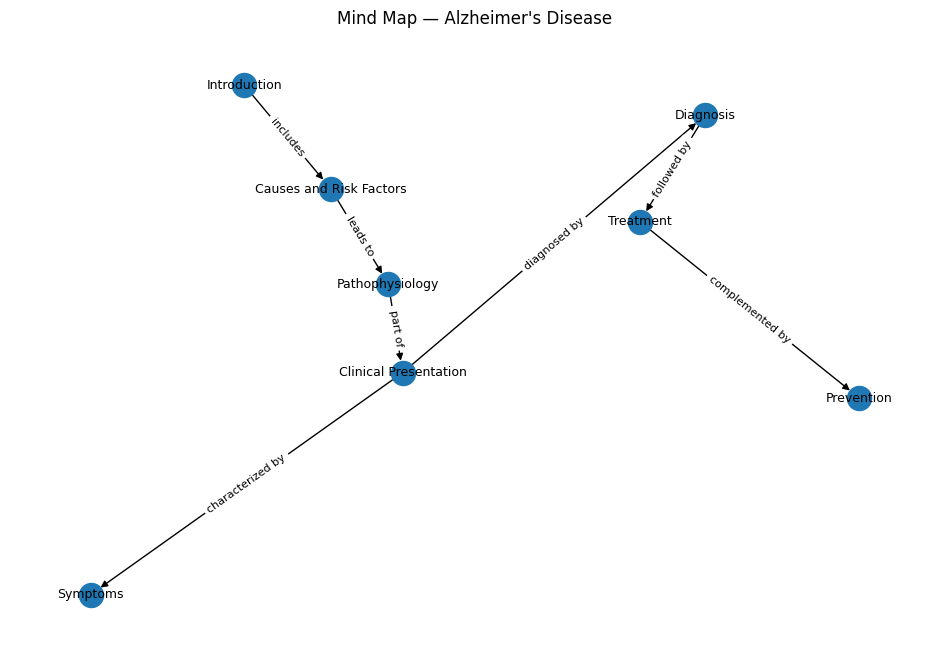

In [ ]:
def draw_mind_map(mm: dict, figsize=(12, 8)):
    G = nx.DiGraph()
    root = mm.get("root", "Root")

    # add nodes
    for n in mm.get("nodes", []):
        G.add_node(n["id"], label=n["label"])

    # add edges
    for e in mm.get("edges", []):
        G.add_edge(e["source"], e["target"], label=e.get("label", ""))

    # layout
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=True)
    labels = {n: G.nodes[n].get("label", n) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # edge labels
    edge_labels = {(u, v): G.edges[u, v].get("label", "") for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Mind Map — {root}")
    plt.axis("off")
    plt.show()

draw_mind_map(mm)


In [ ]:
PROMPT_MINDMAP_TREE = ChatPromptTemplate.from_messages([
    ("system", BASE_SYSTEM),
    ("human", """
STUDENT PROFILE:
{profile}

DOCUMENT CONTEXT (ONLY SOURCE OF TRUTH):
{context}

TASK: Build a hierarchical mind map (TREE) strictly from the CONTEXT for the topic below.

TOPIC:
{topic}

RULES:
- Use ONLY the CONTEXT. No outside knowledge.
- If the topic is not covered, say: "I don't know from the provided documents."
- Keep it concise and study-friendly.
- Use short labels (2-6 words).
- Depth: 3 levels max (Root -> Level1 -> Level2). No more.

OUTPUT MUST BE VALID JSON ONLY (no markdown, no extra text) with this schema:
{{
  "root": "Main Topic",
  "children": [
    {{
      "label": "Branch 1",
      "children": [
        {{"label": "Subpoint 1"}},
        {{"label": "Subpoint 2"}}
      ]
    }},
    {{
      "label": "Branch 2",
      "children": [
        {{"label": "Subpoint 1"}}
      ]
    }}
  ]
}}

CONSTRAINTS:
- 6 to 10 main branches.
- Each branch: 2 to 5 subpoints.
""")
])

def extract_json(text: str) -> dict:
    m = re.search(r"\{.*\}", text, re.DOTALL)
    if not m:
        raise ValueError("No JSON found in model output")
    return json.loads(m.group(0))

In [ ]:
def mind_map_tree(topic: str, k: int = 12) -> dict:
    ctx = retrieve_context(topic if topic.strip() else "main topics", k=k)
    out = llm.invoke(PROMPT_MINDMAP_TREE.format(
        profile=format_profile(profile),
        context=ctx,
        topic=topic
    )).content

    if "I don't know from the provided documents" in out:
        return {"root": topic, "children": []}

    return extract_json(out)

mm_tree = mind_map_tree("PUT YOUR TOPIC HERE")
mm_tree


{'root': "Alzheimer's Disease",
 'children': [{'label': 'Definition',
   'children': [{'label': 'Progressive Disorder'},
    {'label': 'Neurodegenerative'},
    {'label': 'Memory Loss'}]},
  {'label': 'Causes',
   'children': [{'label': 'Genetics'},
    {'label': 'Age'},
    {'label': 'Lifestyle'}]},
  {'label': 'Risk Factors',
   'children': [{'label': 'Family History'},
    {'label': 'Cardiovascular'},
    {'label': 'Brain Injury'}]},
  {'label': 'Symptoms',
   'children': [{'label': 'Mild Forgetfulness'},
    {'label': 'Confusion'},
    {'label': 'Personality Changes'}]},
  {'label': 'Stages',
   'children': [{'label': 'Early Stage'},
    {'label': 'Middle Stage'},
    {'label': 'Late Stage'}]},
  {'label': 'Diagnosis',
   'children': [{'label': 'Clinical Evaluation'},
    {'label': 'Cognitive Testing'},
    {'label': 'Brain Imaging'}]},
  {'label': 'Treatment',
   'children': [{'label': 'Medications'},
    {'label': 'Non-Pharmacological'},
    {'label': 'Lifestyle Changes'}]},
  {'

In [ ]:
def print_tree(node, indent=""):
    if "root" in node:
        print(node["root"])
        for ch in node.get("children", []):
            print_tree(ch, indent="  ")
    else:
        print(f"{indent}- {node.get('label','')}")
        for ch in node.get("children", []):
            print_tree(ch, indent + "  ")

print_tree(mm_tree)


Alzheimer's Disease
  - Definition
    - Progressive Disorder
    - Neurodegenerative
    - Memory Loss
  - Causes
    - Genetics
    - Age
    - Lifestyle
  - Risk Factors
    - Family History
    - Cardiovascular
    - Brain Injury
  - Symptoms
    - Mild Forgetfulness
    - Confusion
    - Personality Changes
  - Stages
    - Early Stage
    - Middle Stage
    - Late Stage
  - Diagnosis
    - Clinical Evaluation
    - Cognitive Testing
    - Brain Imaging
  - Treatment
    - Medications
    - Non-Pharmacological
    - Lifestyle Changes
  - Prevention
    - Physical Activity
    - Healthy Diet
    - Mental Stimulation


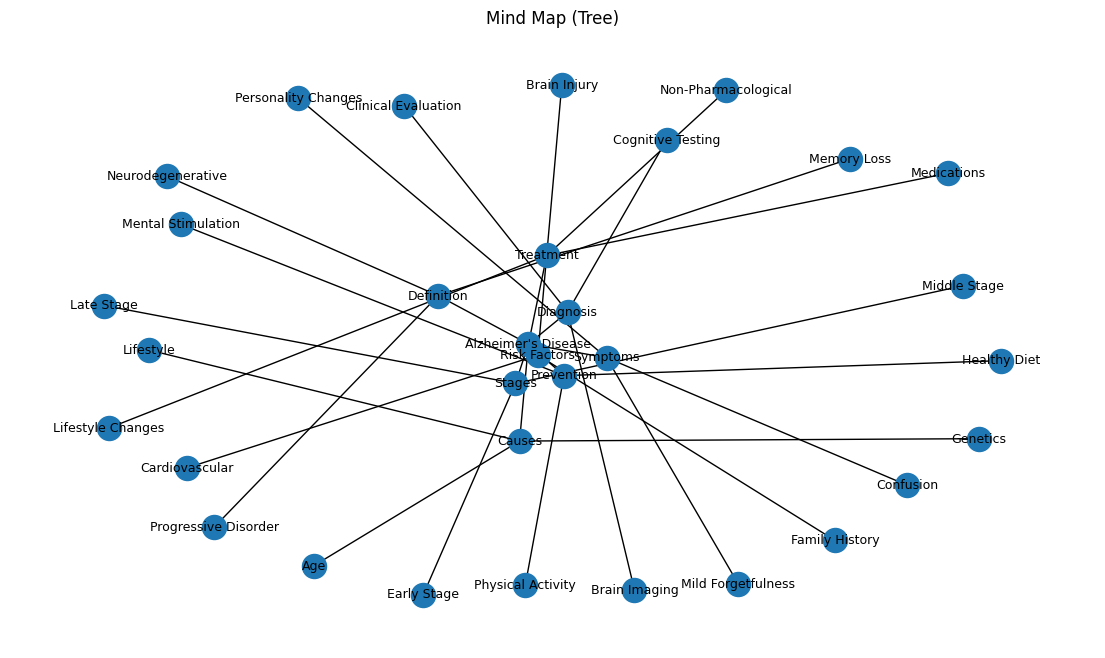

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def tree_to_graph(mm: dict):
    G = nx.DiGraph()
    root = mm.get("root", "Root")
    root_id = "ROOT"
    G.add_node(root_id, label=root)

    def add_children(parent_id, children):
        for idx, child in enumerate(children):
            child_id = f"{parent_id}_{idx}"
            G.add_node(child_id, label=child["label"])
            G.add_edge(parent_id, child_id)
            if "children" in child:
                add_children(child_id, child["children"])

    add_children(root_id, mm.get("children", []))
    return G

def draw_tree(mm: dict, figsize=(14, 8)):
    G = tree_to_graph(mm)

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=False)

    labels = {n: G.nodes[n]["label"] for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.axis("off")
    plt.title("Mind Map (Tree)")
    plt.show()

draw_tree(mm_tree)


Alzheimer's Disease
  - Introduction
    - Definition
    - Overview
  - Causes
    - Genetics
    - Lifestyle
    - Age
  - Symptoms
    - Early Stage
    - Middle Stage
    - Late Stage
  - Diagnosis
    - Clinical Evaluation
    - Cognitive Testing
  - Treatment
    - Medications
    - Non-pharmacological
  - Prevention
    - Lifestyle Habits
    - Diet


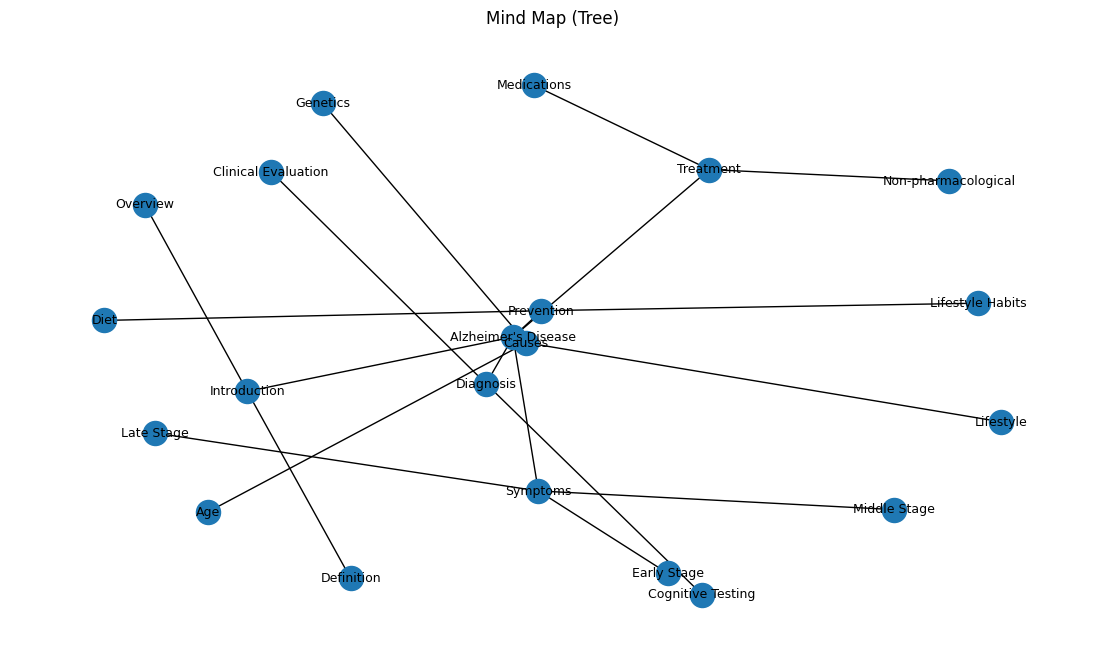

In [ ]:
mm_all = mind_map_tree("Document Overview / Main Topics", k=16)
print_tree(mm_all)
draw_tree(mm_all)


## 9. API Deployment (FastAPI + Ngrok)

This section exposes the AI system as an API.

Endpoints:
- `/generate`
- `/mindmap_tree`
- `/ingest_pdf`

This allows:
- Web apps
- Mobile apps
- External tools  
to interact with the AI Second Brain.


In [ ]:
!pip -q install fastapi uvicorn pyngrok python-multipart


In [ ]:

API_KEY = os.getenv("API_KEY", "secret123")
NGROK_TOKEN = os.getenv("NGROK_TOKEN", "34r6xrTMnnfrEwHn9L1a5OmrPCk_cQLijUL3eh7aAR2kW6bq")

if not NGROK_TOKEN:
    raise ValueError("NGROK_TOKEN is empty. Set it via env var NGROK_TOKEN or hardcode it in the cell.")


def free_port() -> int:
    s = socket.socket()
    s.bind(("", 0))
    port = s.getsockname()[1]
    s.close()
    return port


app = FastAPI(title="AI Second Brain for PDFs API")

def _auth(req: Request):
    if req.headers.get("authorization") != f"Bearer {API_KEY}":
        raise HTTPException(status_code=401, detail="Unauthorized")

@app.get("/health")
def health():
    return {"status": "ok"}


ModeType = Literal[
    "explain", "summarize", "quiz", "flashcards",
    "study_plan", "topic_index", "exam_style", "weakness",
    "custom"
]

class GenerateReq(BaseModel):
    mode: ModeType = "explain"
    topic: str = ""
    k: int = 6

    task_instructions: Optional[str] = None

    qa_block: Optional[str] = None

def _get_prompt_by_mode(mode: str):
    if mode == "explain":
        return PROMPT_EXPLAIN
    if mode == "summarize":
        return PROMPT_SUMMARIZE
    if mode == "quiz":
        return PROMPT_QUIZ
    if mode == "flashcards":
        return PROMPT_FLASHCARDS
    if mode == "study_plan":
        return PROMPT_STUDY_PLAN
    if mode == "topic_index":
        return PROMPT_TOPIC_INDEX
    if mode == "exam_style":
        return PROMPT_EXAM_STYLE
    if mode == "weakness":
        return PROMPT_WEAKNESS
    return None


@app.post("/generate")
async def generate(req: Request, body: GenerateReq):
    _auth(req)

    mode = body.mode
    topic = (body.topic or "").strip()
    k = body.k

    if mode == "custom":
        if not body.task_instructions:
            raise HTTPException(status_code=400, detail="task_instructions is required for mode='custom'")
        tmp_prompt = make_prompt(body.task_instructions)
        response = run_mode(tmp_prompt, topic=topic, k=k)
        return {"response": response}

    prompt = _get_prompt_by_mode(mode)
    if prompt is None:
        raise HTTPException(status_code=400, detail=f"Unsupported mode: {mode}")

    if mode == "weakness":
        if not body.qa_block:
            raise HTTPException(status_code=400, detail="qa_block is required for mode='weakness'")
        response = run_mode(prompt, topic=topic, k=k, qa_block=body.qa_block)
        return {"response": response}

    response = run_mode(prompt, topic=topic, k=k)
    return {"response": response}


class MindmapReq(BaseModel):
    topic: str
    k: int = 12

@app.post("/mindmap_tree")
async def mindmap_tree_api(req: Request, body: MindmapReq):
    _auth(req)
    data = mind_map_tree(body.topic, k=body.k)
    return {"mindmap": data}


UPLOAD_DIR = "uploaded_pdfs"
os.makedirs(UPLOAD_DIR, exist_ok=True)

def _read_pdf_text_local(pdf_path: str) -> str:
    reader = PdfReader(pdf_path)
    parts = []
    for page in reader.pages:
        parts.append(page.extract_text() or "")
    return "\n".join(parts).strip()

@app.post("/ingest_pdf")
async def ingest_pdf(req: Request, file: UploadFile = File(...), chunk_size: int = 1000, overlap: int = 20):
    _auth(req)

    if not file.filename.lower().endswith(".pdf"):
        raise HTTPException(status_code=400, detail="Only PDF files are supported.")

    save_path = os.path.join(UPLOAD_DIR, file.filename)
    content = await file.read()
    with open(save_path, "wb") as f:
        f.write(content)

    text = _read_pdf_text_local(save_path)
    if not text:
        raise HTTPException(status_code=400, detail="Could not extract text from the PDF.")

    doc = Document(page_content=text, metadata={"source": file.filename})

    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    new_chunks = splitter.split_documents([doc])

    vs.add_documents(new_chunks)

    return {
        "message": "PDF ingested successfully",
        "filename": file.filename,
        "chunks_added": len(new_chunks),
    }


In [ ]:
port = free_port()
conf.get_default().auth_token = NGROK_TOKEN

public_url = ngrok.connect(port).public_url
print("✅ Public URL:", public_url)

def run():
    uvicorn.run(app, host="0.0.0.0", port=port, log_level="warning")

threading.Thread(target=run, daemon=True).start()
time.sleep(1)

print("✅ Example endpoints:")
print(public_url + "/health")
print(public_url + "/generate")
print(public_url + "/mindmap_tree")
print(public_url + "/ingest_pdf")


✅ Public URL: https://parheliacal-fruitless-regenia.ngrok-free.dev
✅ Example endpoints:
https://parheliacal-fruitless-regenia.ngrok-free.dev/health
https://parheliacal-fruitless-regenia.ngrok-free.dev/generate
https://parheliacal-fruitless-regenia.ngrok-free.dev/mindmap_tree
https://parheliacal-fruitless-regenia.ngrok-free.dev/ingest_pdf


## 10. API Testing

Testing endpoints using Python requests  
after exposing the server via Ngrok.


In [ ]:

URL = public_url + "/generate"
headers = {"Authorization": "Bearer secret123"}

payload = {
    "mode": "explain",
    "topic": "Alzheimer's Disease",
    "k": 6
}

res = requests.post(URL, headers=headers, json=payload)
print(res.json()["response"])

## 1. Title
Alzheimer's Disease: Understanding the Basics

## 2. Key Ideas
* Alzheimer's disease is a progressive neurodegenerative disorder.
* It is the most common cause of dementia worldwide.
* The disease is characterized by the abnormal buildup of proteins in the brain.
* Symptoms include memory loss, thinking abilities, behavior, and capacity to perform daily activities.
* There is currently no cure for Alzheimer's disease.
* Treatment focuses on symptom management and slowing progression.
* Lifestyle habits such as regular physical activity and a healthy diet may reduce the risk.

## 3. Explanation
Alzheimer's disease is a complex condition that affects millions of people worldwide. To understand it, let's break it down step by step:
- **Step 1: Definition** - Alzheimer's disease is a progressive neurodegenerative disorder, meaning it worsens over time and affects the brain.
- **Step 2: Causes and Risk Factors** - While the exact cause is not fully understood, factors such as ag

# Thanks